In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp
from jax import random

import numpy as onp
from numpy.polynomial.hermite import hermgauss

import paragami

# GMM libraries
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpgmm_runjingdev.gmm_optimization_lib as gmm_optim_lib
from bnpgmm_runjingdev import gmm_posterior_quantities_lib

# BNP libraries
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation, get_cross_hess
from bnpmodeling_runjingdev import result_loading_utils, influence_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib
from bnpmodeling_runjingdev.bnp_optimization_lib import optimize_kl

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import time

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import influence_function_utils
import gmm_loading_utils

# Load data

We load and plot the iris dataset

In [3]:
# load iris data
dataset_name = 'iris'
iris_obs, iris_species = utils_lib.load_iris_data()
dim = iris_obs.shape[1]
n_obs = len(iris_species)

iris_obs = np.array(iris_obs)

Text(0, 0.5, 'PC2')

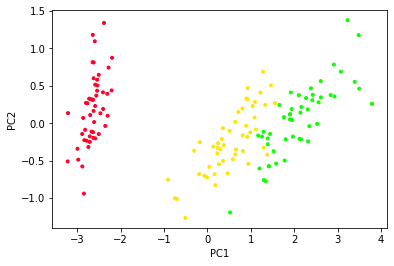

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_obs)
pc_iris_obs = pca_fit.transform(iris_obs)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# file paths

In [5]:
out_folder = '../fits/'
out_filename = 'iris_fit'

In [6]:
alpha0 = 6.0

# Load initial fit

In [7]:
init_fit_file = out_folder + out_filename + '_alpha' + str(alpha0) + '.npz'
print(init_fit_file)

../fits/iris_fit_alpha6.0.npz


In [8]:
vb_opt, vb_opt_dict, e_z_opt, \
 vb_params_paragami, \
    prior_params_dict, \
        gh_loc, gh_weights = gmm_loading_utils.load_initial_fit(init_fit_file, iris_obs)

In [12]:
assert prior_params_dict['dp_prior_alpha'] == alpha0

### Check results

In [13]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]
    
    utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[np.unique(bnp_clusters), :], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters), :, :])


In [14]:
bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_opt_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_opt_dict['cluster_params']['cluster_info']))

In [15]:
bnp_centroids_pc.shape

(15, 4)

### Plot centroids

Text(0, 0.5, 'PC2')

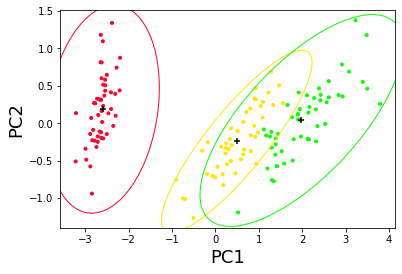

In [16]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


In [17]:
def get_e_num_obs_per_cluster(vb_params_dict): 
    ez = gmm_posterior_quantities_lib.get_optimal_z_from_vb_dict(iris_obs,
                               vb_params_dict,
                               gh_loc,
                               gh_weights,
                               use_bnp_prior = True)
    return ez.sum(0)

In [18]:
e_num_obs_per_cluster = get_e_num_obs_per_cluster(vb_opt_dict)
mixture_weights = gmm_posterior_quantities_lib.get_e_mixture_weights_from_vb_dict(vb_opt_dict, gh_loc, gh_weights)

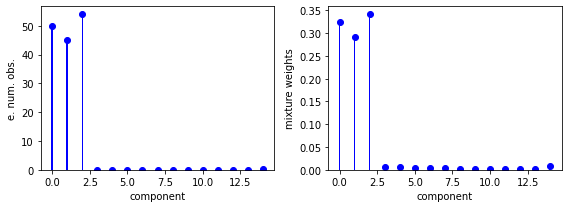

In [19]:
fig, axarr = plt.subplots(1, 2, figsize = (8, 3))

result_loading_utils._plot_weights(e_num_obs_per_cluster, 
                                   axarr[0])

result_loading_utils._plot_weights(mixture_weights, 
                                   axarr[1])


axarr[0].set_ylabel('e. num. obs.')
axarr[1].set_ylabel('mixture weights')
    
fig.tight_layout()

# Some wrappers to compute the influence function and posterior statistics

In [20]:
# contains methods to compute influence functions. 
# this compiles the hessian solver, so takes about a minute
infl_funs = influence_function_utils.InfluenceFunctions(iris_obs, 
                                                       vb_opt, 
                                                       vb_params_paragami, 
                                                       prior_params_dict, 
                                                       gh_loc, gh_weights)

Compiling hessian solver ...
Hessian solver compile time: 58.9597sec

Compiling cross hessian...
Cross-hessian compile time: 0.717684sec

LR sensitivity time: 0.0208454sec



In [21]:
# contains the posterior statistics
post_stats = influence_function_utils.PosteriorStatistics(iris_obs, 
                                                          vb_params_paragami, 
                                                          gh_loc, 
                                                          gh_weights)

# Influence functions

In [22]:
logit_v_grid = np.linspace(-8, 8, 500)

### Influence function on mixture weights

In [23]:
e_num_ind_results = dict()
for k in range(4): 
    print('##############')
    print('Computing influence for k = {}'.format(k))
    print('##############')
    
    influence_grid, influence_grid_x_prior, ghess = infl_funs.get_influence(lambda x : post_stats.get_mixture_weight_k(x, k), 
                                                                           logit_v_grid)
    
    e_num_ind_results['influence_grid{}'.format(k)] = influence_grid
    e_num_ind_results['influence_grid_x_prior{}'.format(k)] = influence_grid_x_prior
    e_num_ind_results['ghess{}'.format(k)] = ghess
    print('\n')

##############
Computing influence for k = 0
##############
computing gradient ...
Elapsed: 2.028sec
inverting Hessian (twice) ...
Elapsed: 6.229sec


##############
Computing influence for k = 1
##############
computing gradient ...
Elapsed: 0.970sec
inverting Hessian (twice) ...
Elapsed: 2.653sec


##############
Computing influence for k = 2
##############
computing gradient ...
Elapsed: 1.166sec
inverting Hessian (twice) ...
Elapsed: 2.614sec


##############
Computing influence for k = 3
##############
computing gradient ...
Elapsed: 0.932sec
inverting Hessian (twice) ...
Elapsed: 2.621sec




In [24]:
def get_wc_log_phi_grid(influence_grid): 
    # returns log_phi at points logit_v_grid
    # just for plotting
    
    worst_case = influence_lib.WorstCasePerturbation(influence_fun = None, 
                                                    logit_v_grid = logit_v_grid, 
                                                    delta = 1.,
                                                    cached_influence_grid = influence_grid)

    return worst_case.log_phi(logit_v_grid), worst_case.change_points

In [31]:
def plot_influence_grid(influence_grid, influence_grid_x_prior, ax): 
    
    # plot y = 0 line
    for i in range(4): 
        ax[i].axhline(0, color = 'black')
    
    # plot influence function
    ax[0].plot(logit_v_grid, influence_grid, color = '#43a2ca')
    
    # plot prior
    ax[1].plot(logit_v_grid, influence_function_utils.p0(logit_v_grid, alpha0), 
                  color = '#7bccc4')
    
    # plot influence x prior
    ax[2].plot(logit_v_grid, influence_grid_x_prior, color = '#0868ac')
    
    # plot l-inf worst-case perturbation
    wc_log_phi, change_points = get_wc_log_phi_grid(influence_grid)
    ax[3].plot(logit_v_grid, wc_log_phi, color = 'grey')
    ax[3].fill_between(logit_v_grid, 0, wc_log_phi, color = 'grey', alpha = 0.5)
    
    ax[0].set_ylabel('influence')
    ax[1].set_ylabel('prior')
    ax[2].set_ylabel('influence x prior')
    ax[3].set_ylabel('worst-case log phi')

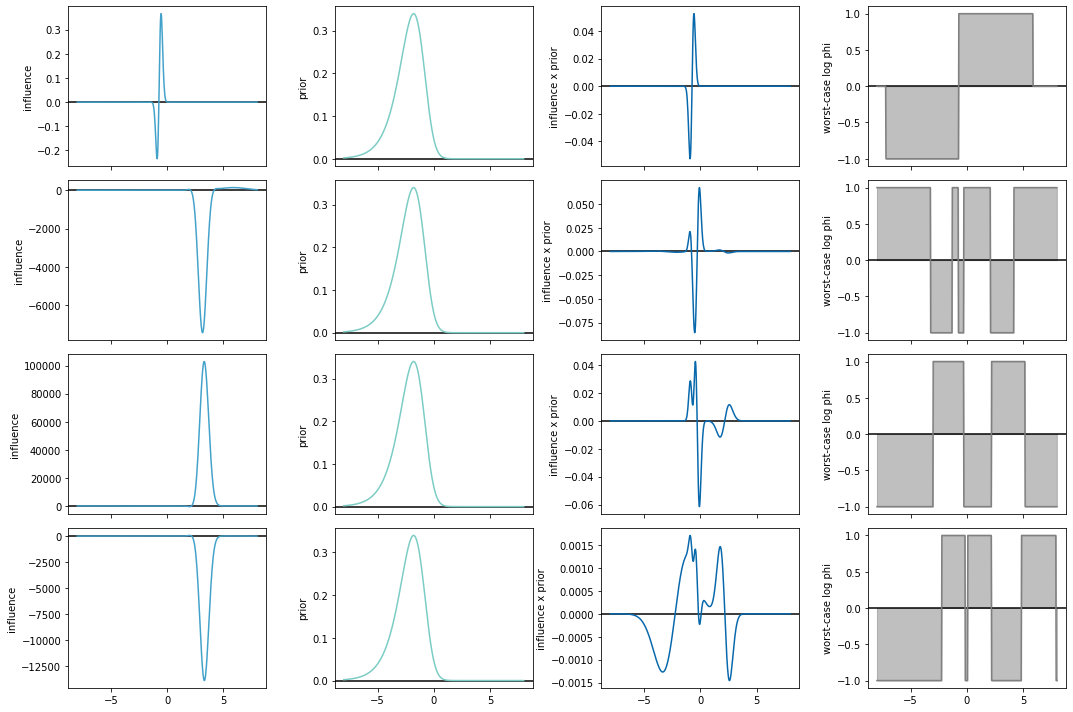

In [32]:
fig, axarr = plt.subplots(4, 4, figsize = (15, 10),  sharex = True) 
for k in range(4): 
    plot_influence_grid(e_num_ind_results['influence_grid{}'.format(k)],
                        e_num_ind_results['influence_grid_x_prior{}'.format(k)],
                        axarr[k])
fig.tight_layout()

### Influence function on expected number of clusters

In [33]:
# in sample
infl_num_clust, infl_x_prior_num_clust, ghess_num_clust = \
    infl_funs.get_influence(post_stats.get_n_clusters_insample, 
                            logit_v_grid)

# predictive
infl_num_clust_pred, infl_x_prior_num_clust_pred, ghess_num_clust_pred = \
    infl_funs.get_influence(post_stats.get_n_clusters_pred,
                            logit_v_grid)

computing gradient ...
Elapsed: 7.039sec
inverting Hessian (twice) ...
Elapsed: 2.656sec
computing gradient ...
Elapsed: 3.063sec
inverting Hessian (twice) ...
Elapsed: 2.952sec


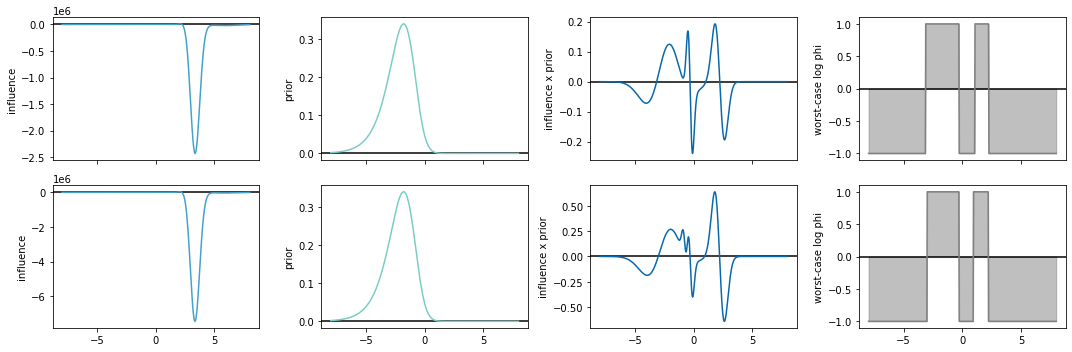

In [34]:
fig, axarr = plt.subplots(2, 4, figsize = (15, 5),  sharex = True) 

plot_influence_grid(infl_num_clust,
                    infl_x_prior_num_clust,
                    axarr[0])

plot_influence_grid(infl_num_clust_pred,
                    infl_x_prior_num_clust_pred,
                    axarr[1])


fig.tight_layout()

# Functions to run worst-case analysis for a given posterior statistic

In [35]:
def get_lr_derivatives(g, ghess, f_obj, epsilon_vec): 
    # g is the posterior statistic
    # g-hess is the gradient of g times the hessian inverse
    # f_obj contains the perturbation
    
    # get cross-hessian
    cross_hess = get_cross_hess(f_obj.hyper_par_objective_fun)(vb_opt, 0.)
    
    # get derivative
    dg_dhyper = np.dot(ghess, -cross_hess)
        
    # get lr results
    lr_g_array = g(vb_opt) + dg_dhyper * epsilon_vec
    
    return lr_g_array

In [36]:
def get_refit_results(f_obj, epsilon_vec): 
    
    # f_obj contains the perturbation 
    # refits for all epsilon in epsilon_vec
    
    # define objective 
    def _f(vb_free, epsilon): 
        
        vb_params_dict = vb_params_paragami.fold(vb_free, 
                                                 free = True)

        return gmm_lib.get_kl(iris_obs, 
                              vb_params_dict,
                              prior_params_dict,
                              gh_loc, gh_weights, 
                              e_log_phi = lambda x, y : f_obj.e_log_phi_epsilon(x, y, epsilon))
    
    
    # jit functions and gradients
    f = jax.jit(_f)
    get_grad = jax.jit(jax.grad(_f, 0))
    
    def _get_hvp(x, epsilon, v):
        return jax.jvp(jax.grad(_f, argnums = 0), (x, epsilon), (v, 0.))[1]

    get_hvp = jax.jit(_get_hvp)
    
    # optimize
    vb_refit_list = []
    for epsilon in epsilon_vec: 
        print('\n################')
        print('re-optimzing with epsilon = ', epsilon)
        print('################')

        vb_opt_pert = optimize_kl(lambda x : f(x, epsilon),
                                 deepcopy(vb_opt_dict), 
                                 vb_params_paragami, 
                                 get_grad = lambda x : get_grad(x, epsilon),
                                 get_hvp = lambda x, v: get_hvp(x, epsilon, v),
                                 run_lbfgs = False,
                                 run_newton = True)[1]                             
        
        vb_refit_list.append(vb_opt_pert)
        
    return vb_refit_list

In [37]:
def run_worst_case_analysis(g, ghess, influence_grid): 
    
    # the class containing the worst-case perturbation
    worst_case = influence_lib.WorstCasePerturbation(influence_fun = None, 
                                                    logit_v_grid = logit_v_grid, 
                                                    delta = 1.,
                                                    cached_influence_grid = influence_grid)
    
    # a wrapper containing the expectations we need for refitting / computing lr
    f_obj = func_sens_lib.FunctionalPerturbationObjective(worst_case.log_phi, 
                                                          vb_params_paragami, 
                                                          e_log_phi = lambda x,y : worst_case.get_e_log_linf_perturbation(x,y), 
                                                          gh_loc = gh_loc, 
                                                          gh_weights = gh_weights, 
                                                          stick_key = 'stick_params')
    
    # get lr-results
    epsilon_vec = np.linspace(0, 1, 8)[1:]**2 
    g_lr_vec = get_lr_derivatives(g, ghess, f_obj, epsilon_vec)
    
    # now get refit results
    vb_refit_list = get_refit_results(f_obj, epsilon_vec)
    
    # get posterior statistic for each refit
    g_refit_vec = np.array([g(x) for x in vb_refit_list])
    
    return g_refit_vec, g_lr_vec, epsilon_vec, vb_refit_list, f_obj

In [67]:
def plot_results(logit_v_grid, 
                 influence_x_prior_grid, 
                 f_obj,
                 epsilon_vec, 
                 refit_g_vec, 
                 lr_g_vec): 
    
        fig, ax = plt.subplots(1, 4, figsize = (14, 3.5))
        
        ###################
        # plot prior x influence function 
        ###################
        ax[0].plot(logit_v_grid, influence_x_prior_grid)
        # plot y = 0
        ax[0].axhline(0, color = 'black')
                
        # overlay bump
        ax[0].plot(logit_v_grid, 
                   f_obj.log_phi(logit_v_grid),
                   color = 'grey')
        
        ax[0].fill_between(logit_v_grid, 
                           0,
                           f_obj.log_phi(logit_v_grid),
                           color = 'grey',
                           alpha = 0.5)
        ax[0].set_ylim((influence_x_prior_grid.min() * 0.95, 
                         influence_x_prior_grid.max() * 1.05))
        ax[0].set_xlim('influence x prior')
        
        ###################
        # plot perturbed prior 
        ###################
        # compute perturbed prior
        prior_perturbation = func_sens_lib.PriorPerturbation(
                                    alpha0 = alpha0,
                                    log_phi = f_obj.log_phi, 
                                    logit_v_ub = 10, 
                                    logit_v_lb = -10)
        
        prior_perturbation._plot_priors(ax[1])
        prior_perturbation._plot_priors_constrained(ax[2])
        ax[2].legend()

        for j in range(3): 
            ax[j].set_xlabel('logit-sticks')

        ###################
        # plot posterior statistic 
        ###################                        
        # plot refit results
        ax[3].plot(epsilon_vec,
                      refit_g_vec - refit_g_vec[0], 
                      '-o', 
                      label = 'refit')

        # plot lr results
        ax[3].plot(epsilon_vec, 
                      lr_g_vec - lr_g_vec[0], 
                      '-o', 
                      label = 'lr')
                
        ax[3].set_xlabel('epsilon')
        ax[3].axhline(0, color = 'black')
        
        ax[3].legend()
        ax[3].set_ylabel('g(pert) - g(init)')
    
        fig.tight_layout()

In [68]:
def run_analysis_and_plot(g, ghess, influence_grid, infl_x_prior_grid): 
    refit_g_vec, lr_g_vec, epsilon_vec, vb_refit_list, f_obj = \
        run_worst_case_analysis(g, ghess, influence_grid)
    
    plot_results(logit_v_grid, 
                 infl_x_prior_grid, 
                 f_obj,
                 epsilon_vec, 
                 refit_g_vec, 
                 lr_g_vec)

# Now actually get results


################
re-optimzing with epsilon =  0.02040816326530612
################
compiling objective and derivatives ... 
done. Compile time: 23.968sec
Running trust-ncg ... 
Newton time: 0.168sec
Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.08163265306122448
################
compiling objective and derivatives ... 
done. Compile time: 1.435sec
Running trust-ncg ... 
Newton time: 0.243sec
Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.18367346938775508
################
compiling objective and derivatives ... 
done. Compile time: 1.427sec
Running trust-ncg ... 
Newton time: 0.282sec
Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.32653061224489793
################
compiling objective and derivatives ... 
done. Compile time: 1.418sec
Running trust-ncg ... 
Newton time: 0.331sec
Optimization terminated successfully.
done. 

################
re-op

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.170746e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.034908e-01
  warnings.warn(


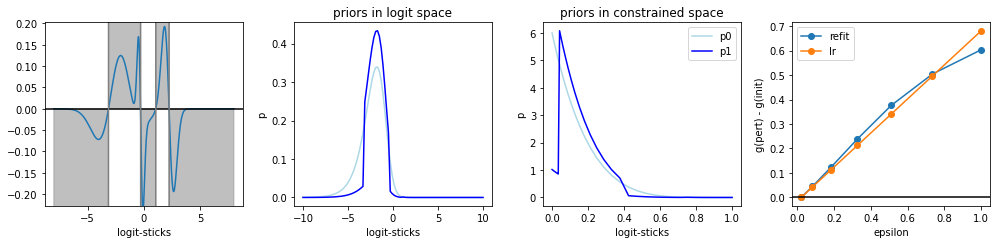

In [69]:
run_analysis_and_plot(post_stats.get_n_clusters_insample, 
                        ghess_num_clust,
                        infl_num_clust,
                        infl_x_prior_num_clust)


################
re-optimzing with epsilon =  0.02040816326530612
################
compiling objective and derivatives ... 
done. Compile time: 23.382sec
Running trust-ncg ... 
Newton time: 0.181sec
Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.08163265306122448
################
compiling objective and derivatives ... 
done. Compile time: 1.434sec
Running trust-ncg ... 
Newton time: 0.227sec
Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.18367346938775508
################
compiling objective and derivatives ... 
done. Compile time: 1.430sec
Running trust-ncg ... 
Newton time: 0.303sec
Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.32653061224489793
################
compiling objective and derivatives ... 
done. Compile time: 1.423sec
Running trust-ncg ... 
Newton time: 0.337sec
Optimization terminated successfully.
done. 

################
re-op

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.587253e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.772089e-01
  warnings.warn(


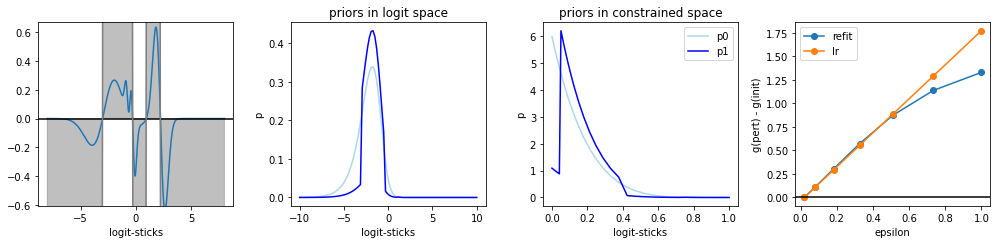

In [70]:
run_analysis_and_plot(post_stats.get_n_clusters_pred, 
                        ghess_num_clust_pred,
                        infl_num_clust_pred,
                        infl_x_prior_num_clust_pred)


################
re-optimzing with epsilon =  0.02040816326530612
################
compiling objective and derivatives ... 
done. Compile time: 24.000sec
Running trust-ncg ... 
Newton time: 0.183sec
Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.08163265306122448
################
compiling objective and derivatives ... 
done. Compile time: 1.431sec
Running trust-ncg ... 
Newton time: 0.141sec
Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.18367346938775508
################
compiling objective and derivatives ... 
done. Compile time: 1.424sec
Running trust-ncg ... 
Newton time: 0.251sec
Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.32653061224489793
################
compiling objective and derivatives ... 
done. Compile time: 1.445sec
Running trust-ncg ... 
Newton time: 0.262sec
Optimization terminated successfully.
done. 

################
re-op

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.242006e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.528160e-01
  warnings.warn(


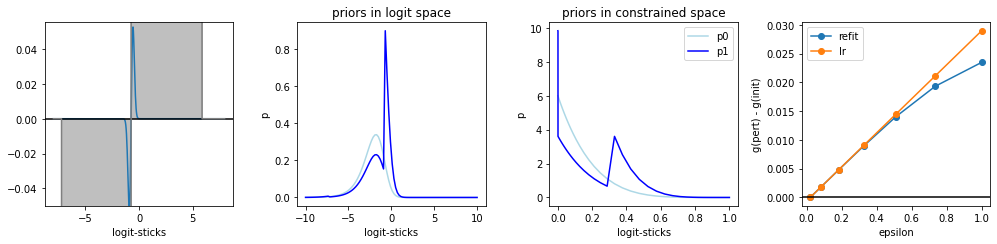

In [71]:
k = 0

run_analysis_and_plot(lambda x : post_stats.get_mixture_weight_k(x, k), 
             e_num_ind_results['ghess{}'.format(k)], 
             e_num_ind_results['influence_grid{}'.format(k)],
             e_num_ind_results['influence_grid_x_prior{}'.format(k)])



################
re-optimzing with epsilon =  0.02040816326530612
################
compiling objective and derivatives ... 
done. Compile time: 23.418sec
Running trust-ncg ... 
Newton time: 0.261sec
Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.08163265306122448
################
compiling objective and derivatives ... 
done. Compile time: 1.461sec
Running trust-ncg ... 
Newton time: 0.257sec
Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.18367346938775508
################
compiling objective and derivatives ... 
done. Compile time: 1.428sec
Running trust-ncg ... 
Newton time: 0.250sec
Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.32653061224489793
################
compiling objective and derivatives ... 
done. Compile time: 1.436sec
Running trust-ncg ... 
Newton time: 0.392sec
Optimization terminated successfully.
done. 

################
re-op

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.201109e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.997488e-04
  warnings.warn(


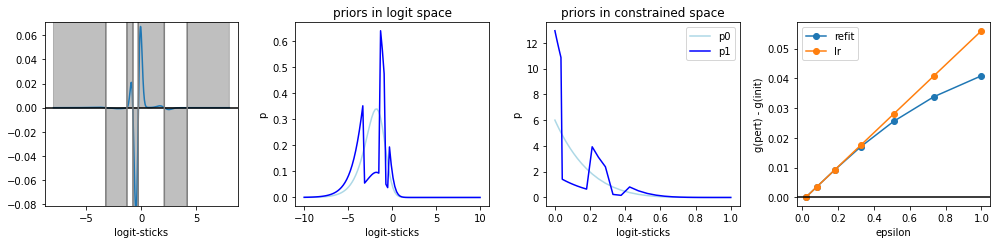

In [72]:
k = 1

run_analysis_and_plot(lambda x : post_stats.get_mixture_weight_k(x, k), 
             e_num_ind_results['ghess{}'.format(k)], 
             e_num_ind_results['influence_grid{}'.format(k)],
             e_num_ind_results['influence_grid_x_prior{}'.format(k)])